# Notebook 2 – Using pretrained NeuralLib models

In this notebook we will:

- Load pretrained ECG models from the NeuLib collection (peak detector and denoiser).
- Apply them to example ECG segments with minimal preprocessing.
- Visualise and briefly interpret their outputs.
- Prepare the ground for training from scratch and transfer learning in the next notebooks.


## Why start from pretrained models?

- NeuLib provides **ProductionModel** objects ready to use from a model hub (Hugging Face).
- We can treat these models almost like functions: input an ECG segment, get peaks or a denoised signal as output.
- This notebook shows how to do that in a few lines of code, before we look at training and transfer learning in later notebooks.


#### Import

We start by importing:

- Standard Python and plotting libraries.
- NeuLib's `model_hub` utilities for loading pretrained models.
- A dataset path with ECG segments and peak labels.


In [77]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt

project_path = os.path.abspath("..")
# Add the project directory to sys.path
if project_path not in sys.path:
    sys.path.append(project_path)

import NeuralLib.model_hub as mh
from NeuralLib.architectures import post_process_peaks_binary
from NeuralLib.config import DATASETS_ECG_G

<img src="tutorial_plots/DATA_PATH.png">

#### Load an example ECG segment

We will:

- Pick one noise-affected ECG segment from the dataset.
- Load its binary peak labels (0/1 array).
- Keep this segment as a running example for the rest of the notebook.


In [78]:
# Example: load one ECG segment and (optionally) its reference peaks
path_sig = os.path.join(DATASETS_ECG_G, "mitbih", "x")
path_idx = os.path.join(DATASETS_ECG_G, "mitbih", "y_bin")  # binary labels with peaks

files = sorted(os.listdir(path_sig))
i = random.randint(0, len(files) - 1)
file = files[i]

test_signal = np.load(os.path.join(path_sig, file))
x_min = test_signal.min()
x_max = test_signal.max()
if x_min == x_max:
    test_signal = np.zeros_like(test_signal)
else:
    test_signal = (test_signal - x_min) / (x_max - x_min)
idx = np.load(os.path.join(path_idx, file))  # 0/1 array
peak_indices = np.where(idx == 1)[0]

print("Loaded file:", file, "| signal shape:", test_signal.shape)

Loaded file: 108_seg0012.npy | signal shape: (5400,)


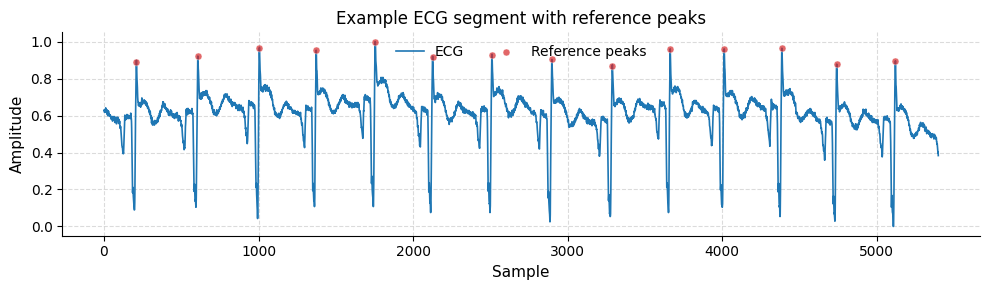

In [79]:
# Visualize the raw ECG
fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(test_signal,color="#1f77b4",linewidth=1.2,label="ECG",
)

ax.scatter(peak_indices,test_signal[peak_indices],facecolors="#d62728",edgecolors="white",
    s=25,alpha=0.7,linewidth=0.4,zorder=3,label="Reference peaks")

ax.set_title("Example ECG segment with reference peaks", fontsize=12)
ax.set_xlabel("Sample", fontsize=11)
ax.set_ylabel("Amplitude", fontsize=11)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(loc="upper center", frameon=False, ncol=3, fontsize=10)
ax.grid(True, which="both", linestyle="--", color="0.8", alpha=0.7)

plt.tight_layout()
plt.show()

## Using a pretrained peak detector

NeuLib exposes pretrained models through a **ProductionModel** API:

- The model is downloaded once (or loaded from cache).
- We only specify a model name, task and device.
- A simple `predict` method takes an ECG segment and returns peaks.

In [80]:
mh.list_production_models()

Models in NeuralLib collection (novabiosignals/neurallib-deep-learning-models-for-biosignals-processing):
ECGPeakDetector
ECGDenoiser


In [81]:
peak_detector = mh.ProductionModel(model_name="ECGPeakDetector")
print(peak_detector)

# Check task type
peak_detector.task, peak_detector.multi_label

Using cached model files at: /Users/groupies/Documents/NOVAProjects/NeuralLib-fork/hugging_prodmodels/ECGPeakDetector
Inferred bidirectionality from checkpoint:
  Layer 0: bidirectional
  Layer 1: bidirectional
  Layer 2: bidirectional
ECGPeakDetector successfully initialized.
ProductionModel(
  (model): GRUseq2seq(
    (gru_layers): ModuleList(
      (0): GRU(1, 32, batch_first=True, bidirectional=True)
      (1): GRU(64, 64, batch_first=True, bidirectional=True)
      (2): GRU(128, 64, batch_first=True, bidirectional=True)
    )
    (dropout_layers): ModuleList(
      (0-2): 3 x Dropout(p=0, inplace=False)
    )
    (fc_out): Linear(in_features=128, out_features=1, bias=True)
    (criterion): BCEWithLogitsLoss()
  )
)


('classification', True)

<img src="tutorial_plots/GRU.png"/>

#### Predict peaks on the example segment

We now:

- Call the pretrained peak detector on our example ECG.
- Optionally apply a small post-processing step to convert the output into discrete peak indices.
- Plot the predicted peaks together with the reference labels.


In [82]:
predicted_peaks = peak_detector.predict(
    X=test_signal,
    gpu_id=None,  # use CPU for the tutorial
    post_process_fn=post_process_peaks_binary,  # convert logits to peak indices
    threshold=0.5,
    filter_peaks=True,
)

No GPU available, using CPU.
Using device: cpu
Prediction Is Done!


#### Visualization of Peak detection

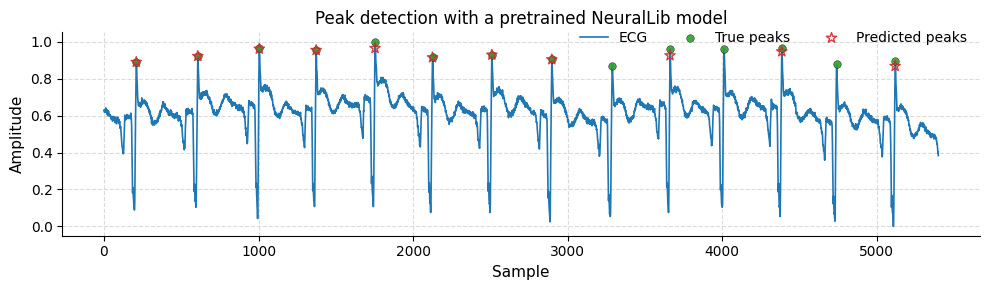

In [100]:
fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(test_signal,color="#1f77b4",linewidth=1.2,label="ECG",
)

ax.scatter(peak_indices,test_signal[peak_indices],color="#2ca02c",s=30,
    alpha=0.9,edgecolor="black",linewidth=0.3,zorder=3,label="True peaks")

ax.scatter(
    predicted_peaks, test_signal[predicted_peaks], facecolors="none", edgecolors="#d62728", s=60,
    marker="*", linewidth=1.0, alpha=0.9, zorder=4, label="Predicted peaks")

ax.set_title("Peak detection with a pretrained NeuralLib model", fontsize=12)
ax.set_xlabel("Sample", fontsize=11)
ax.set_ylabel("Amplitude", fontsize=11)

ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

ax.legend(loc="upper right", bbox_to_anchor=(1.0, 1.07),ncol=3, frameon=False, fontsize=10)
ax.grid(True, which="both", linestyle="--", color="0.8", alpha=0.7)

plt.tight_layout()
plt.show()

## Using a pretrained ECG denoiser

NeuLib also includes pretrained **denoising** models:

- Input: noisy ECG segments.
- Output: denoised versions of the same beats.
- This is useful for improving downstream peak detection or visual inspection.

In [84]:
denoiser = mh.ProductionModel(model_name="ECGDenoiser")

Using cached model files at: /Users/groupies/Documents/NOVAProjects/NeuralLib-fork/hugging_prodmodels/ECGDenoiser
Inferred bidirectionality from checkpoint:
  Layer 0: bidirectional
  Layer 1: unidirectional
ECGDenoiser successfully initialized.


#### Denoise the same ECG segment

We reuse the example segment and:

- Feed it to the denoiser.
- Plot raw vs noisy vs denoised signals.


In [85]:
denoised_ecg = denoiser.predict(
    X=test_signal,
    gpu_id=None,
    post_process_fn=None  # if the model already outputs a waveform
)

No GPU available, using CPU.
Using device: cpu
Prediction Is Done!


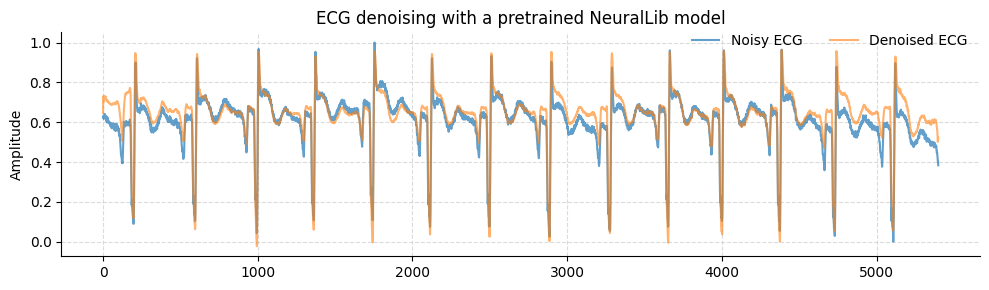

In [101]:
# flatten for plotting
if denoised_ecg.ndim > 1:
    denoised_ecg = denoised_ecg[0].flatten()

fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(test_signal, label="Noisy ECG", alpha=0.7)
ax.plot(denoised_ecg, label="Denoised ECG", alpha=0.6)
ax.set_title("ECG denoising with a pretrained NeuralLib model")
ax.set_ylabel("Amplitude")
ax.legend(loc="upper right", bbox_to_anchor=(1.0, 1.05),ncol=3, frameon=False, fontsize=10)
ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
ax.grid(True, which="both", linestyle="--", color="0.8", alpha=0.7)

ax.set_axisbelow(True) # grid line below data

plt.tight_layout()
plt.show()


In [87]:
peaks_after_denoising = peak_detector.predict(
    X=denoised_ecg,
    gpu_id=None,
    post_process_fn=post_process_peaks_binary,  # convert logits to peak indices
    threshold=0.5,
    filter_peaks=True,
)

No GPU available, using CPU.
Using device: cpu
Prediction Is Done!


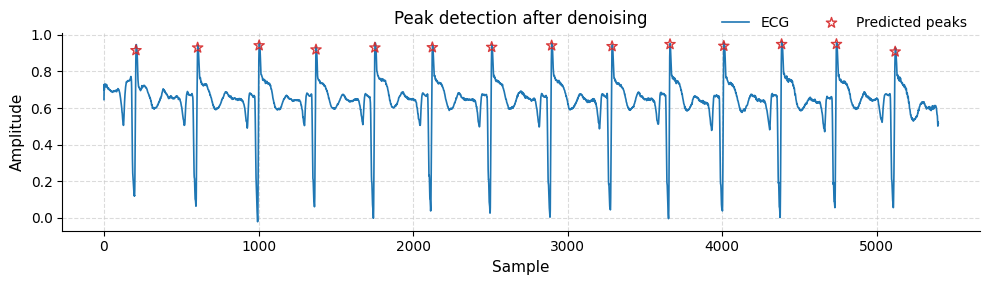

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(denoised_ecg,color="#1f77b4",linewidth=1.2,label="ECG")

ax.scatter(peaks_after_denoising, denoised_ecg[peaks_after_denoising],facecolors="none",
    edgecolors="#d62728", s=60,marker="*", linewidth=1.0, alpha=0.9, zorder=4,label="Predicted peaks")

ax.set_title("Peak detection after denoising", fontsize=12)
ax.set_xlabel("Sample", fontsize=11)
ax.set_ylabel("Amplitude", fontsize=11)
ax.grid(True, which="both", linestyle="--", color="0.8", alpha=0.7)
ax.legend(loc="upper right", bbox_to_anchor=(1.0, 1.15),ncol=3, frameon=False, fontsize=10)

ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

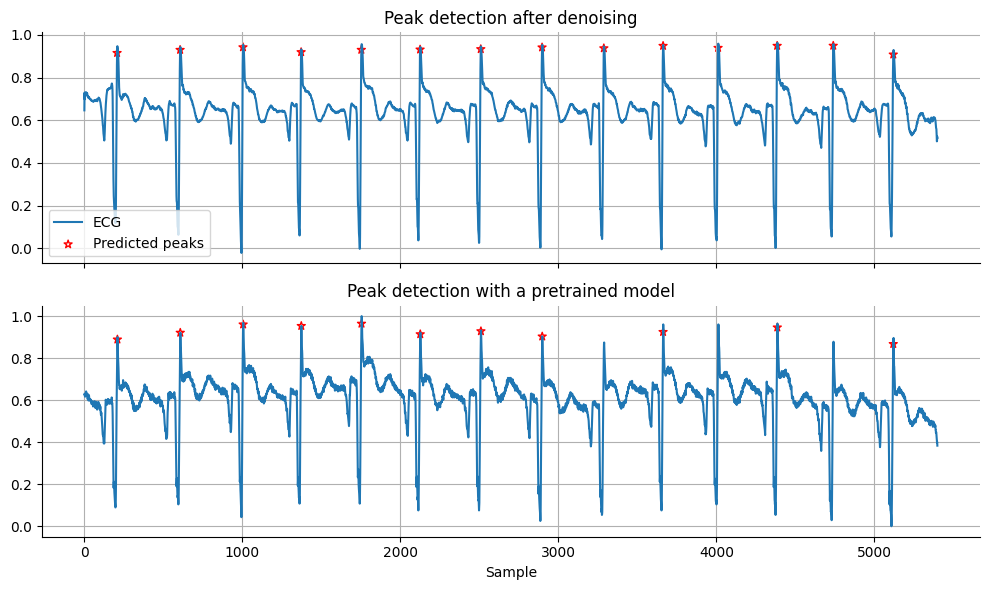

In [105]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(denoised_ecg, label="ECG")
ax1.scatter(peaks_after_denoising,
            denoised_ecg[peaks_after_denoising],
            facecolors="none", edgecolors="r", marker="*", label="Predicted peaks")
ax1.set_title("Peak detection after denoising")
ax1.legend()

ax2.plot(test_signal, label="ECG")
ax2.scatter(predicted_peaks, test_signal[predicted_peaks],
            facecolors="none", edgecolors="r", marker="*", label="Predicted peaks")
ax2.set_title("Peak detection with a pretrained model")
ax2.set_xlabel("Sample")

for ax in (ax1, ax2):
    ax.grid(True)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


## Summary

- We loaded two pretrained ECG models (`ECGPeakDetector` and `ECGDenoiser`) from the NeuralLib collection using the `ProductionModel` API.
- With just a few lines of code, we applied them to real ECG segments and visualized the outputs (peaks and denoised signals).
- In the next notebook, we will look inside the framework and train a small ECG model from scratch using NeuLib’s architectures and training utilities.